In [1]:
import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Dense, Input
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

/home/bpnachman/anaconda3/envs/shared_env2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bpnachman/anaconda3/envs/shared_env2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bpnachman/anaconda3/envs/shared_env2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bpnachman/anacon

In [3]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [4]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

In [5]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'alpha': 0.5, 'density': True}

In [6]:
# Check Versions
print(tf.__version__)  # 1.15.0
print(keras.__version__)  # 2.2.4

1.12.0
2.2.4


# OmniFold Gaussian Toy Example

## Setup the Datasets

In [90]:
mu0 = 0
sigma0 = 1

eff = 0.1 #fraction of true but not reco
fake = 0.1 #fraction of reco but not true

In [91]:
N = 10**5
# param = (mu, sigma)
theta0_param = (mu0, sigma0)  # synthetic sample
theta_unknown_param = (1, 1.5)  # this is the data (the target)
epsilon = sigma0 / 1.  # Smearing width

theta0_G = np.random.normal(theta0_param[0], theta0_param[1],N)  # Generator-level synthetic sample
theta0_S = np.array([(x + np.random.normal(0, epsilon)) for x in theta0_G])  # Detector smearing for synthetic sample
pass_reco = np.random.binomial(1,1.-eff,len(theta0_G))
pass_truth = np.random.binomial(1,1.-fake,len(theta0_G))
theta0_S[pass_reco==0] = -10
theta0_G[pass_truth==0] = -10

theta0 = np.stack([theta0_G, theta0_S], axis=1)
labels0 = np.zeros(len(theta0))

theta_unknown_G = np.random.normal(theta_unknown_param[0],theta_unknown_param[1], N)
theta_unknown_S = np.array([(x + np.random.normal(0, epsilon)) for x in theta_unknown_G]) 
pass_reco = np.random.binomial(1,1.-eff,len(theta_unknown_G))
pass_truth = np.random.binomial(1,1.-fake,len(theta_unknown_G))
theta_unknown_S[pass_reco==0] = -10
theta_unknown_G[pass_truth==0] = -10

theta_unknown = np.stack([theta_unknown_G, theta_unknown_S], axis=1)
labels_unknown = np.ones(len(theta_unknown))

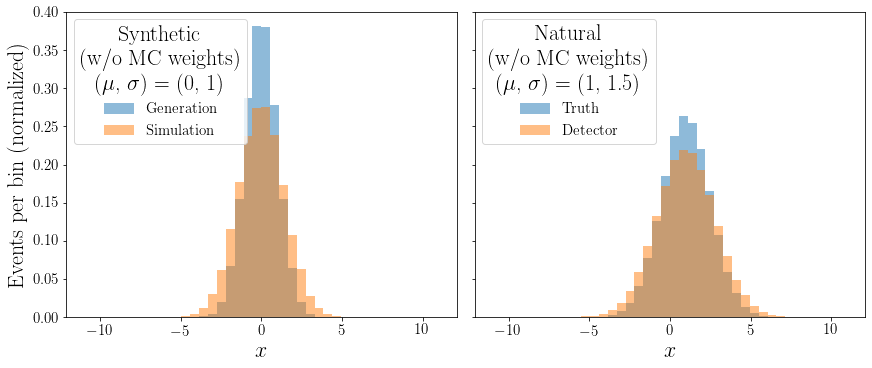

In [92]:
bins = np.linspace(-11, 11, 41)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(theta0_G[theta0_G!=-10], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S[theta0_S!=-10], bins=bins, **plot_style_2, label='Simulation')
legend = ax[0].legend(
    title='Synthetic\n(w/o MC weights)\n($\mu$, $\sigma$) = {}'.format(theta0_param),
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x$')
ax[1].hist(theta_unknown_G[theta_unknown_G!=-10], bins=bins, **plot_style_2, label='Truth')
ax[1].hist(theta_unknown_S[theta_unknown_S!=-10], bins=bins, **plot_style_2, label='Detector')
legend = ax[1].legend(
    title='Natural\n(w/o MC weights)\n($\mu$, $\sigma$) = {}'.format(theta_unknown_param),
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

fig.show()

## Unfold Data

In [104]:
iterations = 5

In [105]:
xvals_1 = np.concatenate((theta0_S, theta_unknown_S))
yvals_1 = np.concatenate((labels0, labels_unknown))

xvals_2 = np.concatenate((theta0_G, theta0_G))
yvals_2 = np.concatenate((labels0, labels_unknown))

weights = np.empty(shape=(iterations, 2, len(theta0)))
# shape = (iteration, step, event)

inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

model = Model(inputs=inputs, outputs=outputs)

earlystopping = EarlyStopping(patience=10,
                              verbose=1,
                              restore_best_weights=True)

In [106]:
# from NN (DCTR)
def reweight(events):
    f = model.predict(events, batch_size=10000)
    weights = f / (1. - f)
    return np.squeeze(np.nan_to_num(weights))

In [107]:
# initial iterative weights are ones

weights_pull = np.ones(len(theta0_S))
weights_push = np.ones(len(theta0_S))

In [108]:
for i in range(iterations):
    print("\nITERATION: {}\n".format(i + 1))

    # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
    # weights reweighted Sim. --> Data
    print("STEP 1\n")

    weights_1 = np.concatenate((weights_push, np.ones(len(theta_unknown_S))))
    # actual weights for Sim., ones for Data (not MC weights)

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
        xvals_1, yvals_1, weights_1)

    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_1[X_train_1!=-10],
              Y_train_1[X_train_1!=-10],
              sample_weight=w_train_1[X_train_1!=-10],
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_1[X_test_1!=-10], Y_test_1[X_test_1!=-10], w_test_1[X_test_1!=-10]),
              callbacks=[earlystopping],
              verbose=1)

    weights_pull = weights_push * reweight(theta0_S)
    weights_pull[theta0_S==-10] = 1. #these are events that don't pass reco; take the prior.
    weights[i, :1, :] = weights_pull

    # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
    # weights Gen. --> reweighted Gen.
    print("\nSTEP 2\n")

    weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
    # ones for Gen. (not MC weights), actual weights for (reweighted) Gen.

    X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
        xvals_2, yvals_2, weights_2)

    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_2,
              Y_train_2,
              sample_weight=w_train_2,
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_2, Y_test_2, w_test_2),
              callbacks=[earlystopping],
              verbose=1)

    weights_push = reweight(theta0_G)
    weights[i, 1:2, :] = weights_push


ITERATION: 1

STEP 1

Train on 135019 samples, validate on 45063 samples
Epoch 1/200
135019/135019 [==============================] - 15s 110us/step - loss: 0.6634 - acc: 0.5974 - val_loss: 0.6490 - val_acc: 0.6137
Epoch 2/200
135019/135019 [==============================] - 0s 1us/step - loss: 0.6449 - acc: 0.6187 - val_loss: 0.6433 - val_acc: 0.6234
Epoch 3/200
135019/135019 [==============================] - 0s 1us/step - loss: 0.6394 - acc: 0.6287 - val_loss: 0.6387 - val_acc: 0.6290
Epoch 4/200
135019/135019 [==============================] - 0s 1us/step - loss: 0.6365 - acc: 0.6321 - val_loss: 0.6372 - val_acc: 0.6317
Epoch 5/200
135019/135019 [==============================] - 0s 1us/step - loss: 0.6358 - acc: 0.6329 - val_loss: 0.6370 - val_acc: 0.6307
Epoch 6/200
135019/135019 [==============================] - 0s 1us/step - loss: 0.6357 - acc: 0.6329 - val_loss: 0.6368 - val_acc: 0.6310
Epoch 7/200
135019/135019 [==============================] - 0s 1us/step - loss: 0.6355 -

150000/150000 [==============================] - 0s 1us/step - loss: 0.6685 - acc: 0.4999 - val_loss: 0.6709 - val_acc: 0.5007
Epoch 14/200
150000/150000 [==============================] - 0s 1us/step - loss: 0.6685 - acc: 0.4998 - val_loss: 0.6709 - val_acc: 0.5007
Epoch 15/200
150000/150000 [==============================] - 0s 1us/step - loss: 0.6685 - acc: 0.4993 - val_loss: 0.6709 - val_acc: 0.5010
Epoch 16/200
150000/150000 [==============================] - 0s 1us/step - loss: 0.6687 - acc: 0.5001 - val_loss: 0.6710 - val_acc: 0.4990
Epoch 17/200
150000/150000 [==============================] - 0s 1us/step - loss: 0.6685 - acc: 0.5000 - val_loss: 0.6709 - val_acc: 0.5009
Restoring model weights from the end of the best epoch
Epoch 00017: early stopping

ITERATION: 2

STEP 1

Train on 135030 samples, validate on 45052 samples
Epoch 1/200
135030/135030 [==============================] - 15s 113us/step - loss: 0.6735 - acc: 0.6314 - val_loss: 0.6728 - val_acc: 0.6213
Epoch 2/200
13

135030/135030 [==============================] - 0s 1us/step - loss: 0.6662 - acc: 0.6297 - val_loss: 0.6710 - val_acc: 0.6244
Epoch 54/200
135030/135030 [==============================] - 0s 1us/step - loss: 0.6661 - acc: 0.6289 - val_loss: 0.6709 - val_acc: 0.6239
Epoch 55/200
135030/135030 [==============================] - 0s 1us/step - loss: 0.6661 - acc: 0.6291 - val_loss: 0.6708 - val_acc: 0.6239
Epoch 56/200
135030/135030 [==============================] - 0s 1us/step - loss: 0.6661 - acc: 0.6298 - val_loss: 0.6708 - val_acc: 0.6233
Epoch 57/200
135030/135030 [==============================] - 0s 1us/step - loss: 0.6662 - acc: 0.6283 - val_loss: 0.6710 - val_acc: 0.6241
Epoch 58/200
135030/135030 [==============================] - 0s 1us/step - loss: 0.6661 - acc: 0.6293 - val_loss: 0.6710 - val_acc: 0.6250
Epoch 59/200
135030/135030 [==============================] - 0s 1us/step - loss: 0.6661 - acc: 0.6287 - val_loss: 0.6712 - val_acc: 0.6249
Epoch 60/200
135030/135030 [=====

150000/150000 [==============================] - 0s 1us/step - loss: 0.6371 - acc: 0.4991 - val_loss: 0.6364 - val_acc: 0.5025
Epoch 22/200
150000/150000 [==============================] - 0s 1us/step - loss: 0.6371 - acc: 0.4991 - val_loss: 0.6364 - val_acc: 0.5026
Restoring model weights from the end of the best epoch
Epoch 00022: early stopping

ITERATION: 3

STEP 1

Train on 135014 samples, validate on 45068 samples
Epoch 1/200
135014/135014 [==============================] - 16s 117us/step - loss: 0.7254 - acc: 0.6308 - val_loss: 0.6807 - val_acc: 0.6322
Epoch 2/200
135014/135014 [==============================] - 0s 1us/step - loss: 0.6756 - acc: 0.6203 - val_loss: 0.6728 - val_acc: 0.6071
Epoch 3/200
135014/135014 [==============================] - 0s 1us/step - loss: 0.6746 - acc: 0.6080 - val_loss: 0.6721 - val_acc: 0.6151
Epoch 4/200
135014/135014 [==============================] - 0s 1us/step - loss: 0.6740 - acc: 0.6200 - val_loss: 0.6719 - val_acc: 0.6246
Epoch 5/200
13501

150000/150000 [==============================] - 0s 1us/step - loss: 0.6261 - acc: 0.4996 - val_loss: 0.6220 - val_acc: 0.5010
Epoch 35/200
150000/150000 [==============================] - 0s 1us/step - loss: 0.6262 - acc: 0.4996 - val_loss: 0.6221 - val_acc: 0.5010
Epoch 36/200
150000/150000 [==============================] - 0s 1us/step - loss: 0.6261 - acc: 0.4996 - val_loss: 0.6220 - val_acc: 0.5011
Epoch 37/200
150000/150000 [==============================] - 0s 1us/step - loss: 0.6261 - acc: 0.4995 - val_loss: 0.6221 - val_acc: 0.5010
Epoch 38/200
150000/150000 [==============================] - 0s 1us/step - loss: 0.6261 - acc: 0.4998 - val_loss: 0.6221 - val_acc: 0.5010
Epoch 39/200
150000/150000 [==============================] - 0s 1us/step - loss: 0.6261 - acc: 0.4996 - val_loss: 0.6221 - val_acc: 0.5011
Epoch 40/200
150000/150000 [==============================] - 0s 1us/step - loss: 0.6262 - acc: 0.4996 - val_loss: 0.6220 - val_acc: 0.5007
Epoch 41/200
150000/150000 [=====

135021/135021 [==============================] - 0s 1us/step - loss: 0.6976 - acc: 0.5877 - val_loss: 0.6914 - val_acc: 0.5821
Epoch 13/200
135021/135021 [==============================] - 0s 1us/step - loss: 0.6976 - acc: 0.5802 - val_loss: 0.6914 - val_acc: 0.5779
Epoch 14/200
135021/135021 [==============================] - 0s 1us/step - loss: 0.6976 - acc: 0.5859 - val_loss: 0.6914 - val_acc: 0.5819
Epoch 15/200
135021/135021 [==============================] - 0s 1us/step - loss: 0.6976 - acc: 0.5803 - val_loss: 0.6913 - val_acc: 0.5848
Epoch 16/200
135021/135021 [==============================] - 0s 1us/step - loss: 0.6976 - acc: 0.5838 - val_loss: 0.6912 - val_acc: 0.6009
Epoch 17/200
135021/135021 [==============================] - 0s 1us/step - loss: 0.6976 - acc: 0.5796 - val_loss: 0.6913 - val_acc: 0.5744
Epoch 18/200
135021/135021 [==============================] - 0s 1us/step - loss: 0.6975 - acc: 0.5907 - val_loss: 0.6912 - val_acc: 0.5817
Epoch 19/200
135021/135021 [=====

135021/135021 [==============================] - 0s 1us/step - loss: 0.6973 - acc: 0.5746 - val_loss: 0.6904 - val_acc: 0.6025
Epoch 71/200
135021/135021 [==============================] - 0s 1us/step - loss: 0.6974 - acc: 0.5943 - val_loss: 0.6905 - val_acc: 0.6095
Epoch 72/200
135021/135021 [==============================] - 0s 1us/step - loss: 0.6976 - acc: 0.5804 - val_loss: 0.6905 - val_acc: 0.5804
Epoch 73/200
135021/135021 [==============================] - 0s 1us/step - loss: 0.6974 - acc: 0.5905 - val_loss: 0.6910 - val_acc: 0.6238
Epoch 74/200
135021/135021 [==============================] - 0s 1us/step - loss: 0.6973 - acc: 0.6062 - val_loss: 0.6907 - val_acc: 0.5880
Epoch 75/200
135021/135021 [==============================] - 0s 1us/step - loss: 0.6973 - acc: 0.5930 - val_loss: 0.6907 - val_acc: 0.5714
Epoch 76/200
135021/135021 [==============================] - 0s 1us/step - loss: 0.6973 - acc: 0.5708 - val_loss: 0.6908 - val_acc: 0.5722
Epoch 77/200
135021/135021 [=====

ITERATION 1:


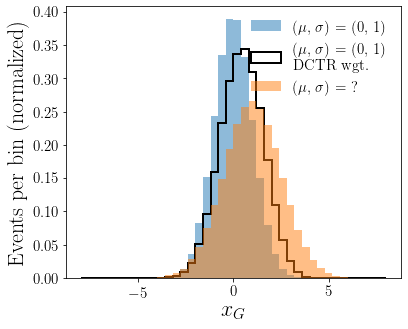

ITERATION 2:


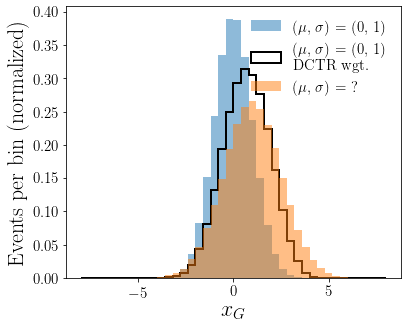

ITERATION 3:


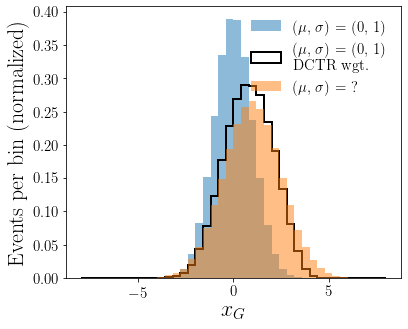

ITERATION 4:


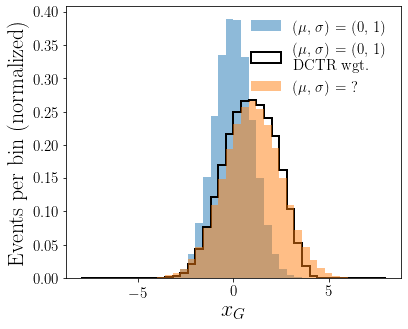

ITERATION 5:


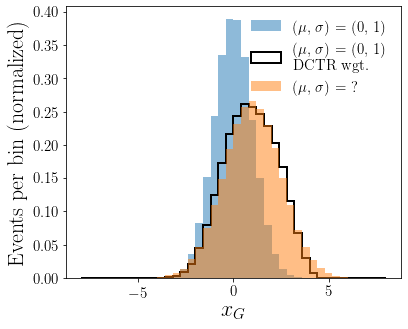

In [109]:
bins = np.linspace(-8, 8, 41)

for i in range(5):
    print("ITERATION {}:".format(i + 1))
    plt.figure(figsize=(6, 5))
    hist0 = plt.hist(theta0_G[theta0_G!=0],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                     **plot_style_2)

    hist1 = plt.hist(
        theta0_G[theta0_G!=0],
        bins=bins,
        label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
        weights=weights[i, 1, :][theta0_G!=0],
        **plot_style_1)
    hist2 = plt.hist(theta_unknown_G[theta_unknown_G!=0],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = ?',
                     **plot_style_2)
    plt.legend(frameon=False)
    plt.xlabel(r"$x_G$")
    plt.ylabel("Events per bin (normalized)")
    plt.show()